report： https://typst.app/project/wCnTjkIeLvgrcBJBBhyQfG

## **Importing Modules**

In [1]:
#pip install torchsummary


In [2]:
#importing required modules

import zipfile
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

import torchvision.models as models
import torch
import torch.nn as nn
from torchsummary import summary
from torchvision import datasets, transforms as T
from torch.utils.data import Dataset, DataLoader

import os
import torch.optim as optim
from PIL import ImageFile

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score, roc_curve


## **Data Preprocessing**

In [3]:
#file split 

# split it into 70:15:15
import os
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split

# Load CSV
df = pd.read_csv("train.csv")

# Split into train/val/test
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['has_cactus'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['has_cactus'], random_state=42)

splits = {
    'train': train_df,
    'valid': val_df,
    'test': test_df
}

# Create directories
for split in splits:
    for label in [0, 1]:
        os.makedirs(f'split/{split}/{label}', exist_ok=True)

# Copy files
for split_name, split_df in splits.items():
    for _, row in split_df.iterrows():
        label = row['has_cactus']
        image_id = row['id']
        src = os.path.join('train/train', image_id)
        dst = os.path.join('split', split_name, str(label), image_id)
        shutil.copy(src, dst)

print("✅ Done splitting and organizing images into split/train, split/val, split/test.")



✅ Done splitting and organizing images into split/train, split/val, split/test.


In [4]:
#importing data

# #Dataset address
# url = 'https://drive.google.com/uc?export=download&id=1B75cOYH7VCaiqdeQYvMuUuy_Mn_5tPMY'
# output = 'data.zip'
# # gdown.download(url, output, quiet=False)

# #giving zip file name
# data_dir='./data.zip'

# #extractng data from zip file
# with zipfile.ZipFile(data_dir, 'r') as zf:
#     zf.extractall('./data')
#     print('Done downloading and extraction')

# #removing zip file after extraction
# !rm './data.zip' 

#invstigating number of files
cactus_files = np.array(glob("./split/*/*/*"))
print('There are %d total  images.' % len(cactus_files))

#checking the availability of a GPU
use_cuda = torch.cuda.is_available()

There are 20126 total  images.


In [18]:
use_cuda = torch.cuda.is_available()

In [19]:
use_cuda

False

In [6]:
transform = T.Compose([T.ToTensor(),])
data_file='./split/'

train_path=os.path.join(data_file,'train')
dataset = datasets.ImageFolder(train_path,transform=transform)
dataloader = DataLoader(dataset, batch_size=1, num_workers=1, shuffle=False)

mean = torch.zeros(3)
std = torch.zeros(3)

for i, data in enumerate(dataloader):
    if (i % 10000 == 0): print(i)
    data = data[0].squeeze(0)
    if (i == 0): size = data.size(1) * data.size(2)
    mean += data.sum((1, 2)) / size

mean /= len(dataloader)
print(mean)
mean = mean.unsqueeze(1).unsqueeze(2)

for i, data in enumerate(dataloader):
    if (i % 10000 == 0): print(i)
    data = data[0].squeeze(0)
    std += ((data - mean) ** 2).sum((1, 2)) / size

std /= len(dataloader)
std = std.sqrt()
print(std)

0
10000
tensor([0.5034, 0.4517, 0.4681])
0
10000
tensor([0.1511, 0.1398, 0.1533])


In [7]:
#declaring batch size
batch_size = 128

#applying required transformations on the dataset
img_transforms = {
    'train':
    T.Compose([
        T.Resize(size=(32,32)), 
        T.ToTensor(),
        T.Normalize(mean, std), 
    ]),
    

    'valid':
    T.Compose([
        T.Resize(size=(32,32)),
        T.ToTensor(),
        T.Normalize(mean, std)
    ]),


    'test':
    T.Compose([
        T.Resize(size=(32,32)),
        T.ToTensor(),
        T.Normalize(mean, std)
    ]),
}



train_path=os.path.join(data_file,'train')
valid_path=os.path.join(data_file,'test')
test_path=os.path.join(data_file,'valid')


# creating datasets to each of  folder created in prev
train_file=datasets.ImageFolder(train_path,transform=img_transforms['train'])
valid_file=datasets.ImageFolder(valid_path,transform=img_transforms['valid'])
test_file=datasets.ImageFolder(test_path,transform=img_transforms['test'])


#creating loaders for the dataset
loaders_transfer={
    'train':torch.utils.data.DataLoader(train_file,batch_size,shuffle=True),
    'valid':torch.utils.data.DataLoader(valid_file,batch_size,shuffle=True),
    'test': torch.utils.data.DataLoader(test_file,batch_size,shuffle=True)
}

## **Model Building**

In [8]:
# Importing the pretrained model
model_transfer = models.resnet50(pretrained=True)

# Freeze weights
for param in model_transfer.parameters():
    param.requires_grad = False

n_inputs = model_transfer.fc.in_features

#Replacing the top dense layers with self defined trainable layers
model_transfer.fc = nn.Sequential(
    nn.Linear(n_inputs, 1024),
    nn.LeakyReLU(inplace = True),

    nn.Linear(1024,512),
    nn.LeakyReLU(inplace=True),
            
    nn.Linear(512,256),
    nn.LeakyReLU(inplace=True),

    nn.Linear(256,64),
    nn.LeakyReLU(inplace=True),

    nn.Linear(64,16),
    nn.LeakyReLU(inplace=True),

    nn.Linear(16,2),
    nn.Sigmoid()
)

#transferring the model to GPU
if use_cuda:
    model_transfer = model_transfer.cuda()

d:\anacoda\envs\Pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\anacoda\envs\Pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
summary(model_transfer, (3, 224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [10]:
# Assuming `train_dataset` contains your training data
class_counts = np.bincount(train_file.targets)  # Get counts per class
class_weights = 1. / class_counts  # Inverse frequency weighting
class_weights = class_weights / class_weights.sum()  # Normalize

# Convert to tensor and move to GPU if needed
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)
if use_cuda:
    class_weights_tensor = class_weights_tensor.cuda()

# Initialize weighted loss function
criterion_transfer = nn.CrossEntropyLoss(weight=class_weights_tensor)

#using Adam optimizer
optimizer_transfer = optim.Adam(model_transfer.fc.parameters(), lr=0.0005)

In [11]:
class_counts

array([3055, 9195], dtype=int64)

In [12]:
class_weights

array([0.75061224, 0.24938776])

## **Training and Validating the Model**



In [13]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.version.cuda)  


2.3.0
False
None


In [15]:

ImageFile.LOAD_TRUNCATED_IMAGES = True

# Creating the function for training
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    trainingloss = []
    validationloss = []

    for epoch in range(1, n_epochs+1):
        # initialize the variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        correct1 = 0.
        total1 = 0.
        correct2 = 0.
        total2 = 0.

        ###################
        # training the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
          
            optimizer.zero_grad()
            output = model(data)

            loss = criterion(output, target)
            
            loss.backward()
            optimizer.step()
           
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            pred = output.data.max(1, keepdim=True)[1]
            # compare predictions
            correct1 += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            total1 += data.size(0)

       
        ######################    
        # validating the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            pred = output.data.max(1, keepdim=True)[1]
            # compare predictions
            correct2 += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            total2 += data.size(0)

      

        # train_loss = train_loss/len(train_file)
        # valid_loss = valid_loss/len(valid_file)

        trainingloss.append(train_loss)
        validationloss.append(valid_loss)
        acc1 = 100. * correct1 / total1
        acc2 =  100. * correct2 / total2
        # printing training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.4f} \tValidation Loss: {:.6f} \tValidation Accuracy: {:.4f}'.format(
            epoch,
            train_loss,
            acc1,
            valid_loss,
            acc2
            ))
        
        ## saving the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), save_path)
            
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            
            valid_loss_min = valid_loss
            
    # return trained model
    return model, trainingloss, validationloss

In [35]:
# training the model

n_epochs=500

model_transfer, train_loss, valid_loss = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

Epoch: 1 	Training Loss: 0.442816 	Training Accuracy: 88.0898 	Validation Loss: 0.387503 	Validation Accuracy: 91.1238
Validation loss decreased (inf --> 0.387503).  Saving model ...
Epoch: 2 	Training Loss: 0.389203 	Training Accuracy: 91.9429 	Validation Loss: 0.378481 	Validation Accuracy: 92.4571
Validation loss decreased (0.387503 --> 0.378481).  Saving model ...
Epoch: 3 	Training Loss: 0.382670 	Training Accuracy: 92.4082 	Validation Loss: 0.378922 	Validation Accuracy: 92.1905
Epoch: 4 	Training Loss: 0.376111 	Training Accuracy: 93.1429 	Validation Loss: 0.383255 	Validation Accuracy: 90.9714


KeyboardInterrupt: 

In [36]:
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

FileNotFoundError: [Errno 2] No such file or directory: 'model_transfer.pt'

In [37]:
train_loss

NameError: name 'train_loss' is not defined

##  **Testing the Model**



In [ ]:
# Defining the test function

def test(loaders, model, criterion, use_cuda):

    # monitoring test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
    preds = []
    targets = []

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # moving to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # updating average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # converting the output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        preds.append(pred)
        targets.append(target)
        # compare predictions
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    # print('Test Loss: {:.7f}\n'.format(test_loss))

    # print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
    #     100. * correct / total, correct, total))
    
    return preds, targets

# calling test function
preds, targets = test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

## **Visulizing the results**

In [27]:
#converting the tensor object to a list for metric functions

preds2, targets2 = [],[]

for i in preds:
  for j in range(len(i)):
    preds2.append(1-i.cpu().numpy()[j])
for i in targets:
  for j in range(len(i)):
    targets2.append(i.cpu().numpy()[j])

Confusion Matrix:
 [[ 556  155]
 [  98 1816]]


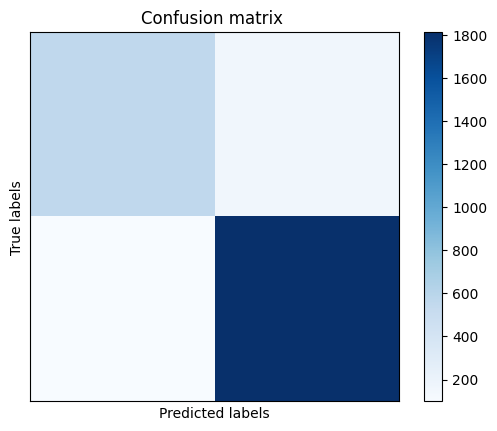

In [28]:
#plotting the confusion matrix for testing data

cm = confusion_matrix(preds2, targets2)
print('Confusion Matrix:\n', cm)
plt.imshow(cm, cmap = plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([], [])
plt.yticks([], [])
plt.title('Confusion matrix ')
plt.colorbar()
plt.show()

AUC score:  0.8857563105395203
Accuracy:  0.9036190476190477
F1 score:  0.9348777348777348
Precision score:  0.9487983281086729
Recall score:  0.9213597158802638


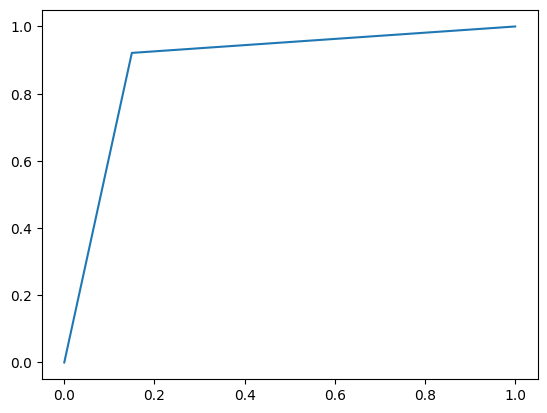

In [29]:
#Computing the 5 evaluation metrics and printing

acc = accuracy_score(targets2, preds2)

fpr, tpr, _ = roc_curve(targets2, preds2)

area = roc_auc_score(targets2, preds2)
print("AUC score: ", area)

print("Accuracy: ", acc)

f1 = f1_score(targets2, preds2)
print("F1 score: ", f1)

pre = precision_score(targets2, preds2)
print("Precision score: ", pre)

recall = recall_score(targets2, preds2)
print("Recall score: ", recall)

plt.plot(fpr, tpr)

#Testing the trained model

In [39]:
#load the trained model
import os
import shutil
import torch
from torchvision import models, transforms
from PIL import Image

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Rebuild the model architecture (must match what you trained)
model = models.resnet50(pretrained=True)

# Freeze weights
for param in model.parameters():
    param.requires_grad = False

n_inputs = model.fc.in_features

#Replacing the top dense layers with self defined trainable layers
model.fc = nn.Sequential(
    nn.Linear(n_inputs, 1024),
    nn.LeakyReLU(inplace = True),

    nn.Linear(1024,512),
    nn.LeakyReLU(inplace=True),
            
    nn.Linear(512,256),
    nn.LeakyReLU(inplace=True),

    nn.Linear(256,64),
    nn.LeakyReLU(inplace=True),

    nn.Linear(64,16),
    nn.LeakyReLU(inplace=True),

    nn.Linear(16,2),
    nn.Sigmoid()
)


# 2. Load the saved state_dict (weights only)
model.load_state_dict(torch.load("model_transfer_resnet.pt", map_location=device))

# 3. Move to device and set to eval mode
model = model.to(device)
model.eval()


# Define the same transform used during training
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean,  # Example: use your actual mean
                         std)   # Example: use your actual std
])



d:\anacoda\envs\Pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\anacoda\envs\Pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# predict in splited test dataet 
# Input folder containing raw images for prediction
input_folder = "split/test/unlabelled"  # ← replace with your folder path
output_base = "split/test/unlabelled/predict"

# Create output folders
for label in ["0", "1"]:
    os.makedirs(os.path.join(output_base, label), exist_ok=True)

# Loop through all images in the input folder
for filename in os.listdir(input_folder):
    if filename.lower().endswith((".jpg", ".png", ".jpeg")):
        image_path = os.path.join(input_folder, filename)

        # Load and preprocess the image
        image = Image.open(image_path).convert("RGB")
        input_tensor = transform(image).unsqueeze(0).to(device)

        # Predict
        with torch.no_grad():
            output = model(input_tensor)
            predicted_class = output.argmax(dim=1).item()  # Get class index with highest score
            label = str(1-predicted_class) # I don't know why but I have to do this to make it work

        # Copy image to predicted folder
        target_path = os.path.join(output_base, label, filename)
        shutil.copy(image_path, target_path)

print("✅ Prediction complete. Results saved in predict/0 and predict/1.")

✅ Prediction complete. Results saved in predict/0 and predict/1.


In [48]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1. Prepare paths
original_test_dir = "split/test"  # Original labeled test data
predicted_dir = "split/test/unlabelled/predict"  # Your prediction results

# 2. Create comparison dataframe
def build_comparison_df(original_root, predicted_root):
    """Build DataFrame containing true labels and predicted labels"""
    
    # Initialize list to store comparison data
    comparison = []
    
    # Iterate through original test directory
    for class_dir in os.listdir(original_root):
        if class_dir not in ["0", "1"]:  
            print(f"Skipping non-class directory: {class_dir}")
            continue
        class_path = os.path.join(original_root, class_dir)
        
        if os.path.isdir(class_path):
            true_label = class_dir  # '0' or '1'
            
            # Check all files in original test class
            for img_file in os.listdir(class_path):
                if img_file.lower().endswith((".jpg", ".png", ".jpeg")):
                    original_path = os.path.join(class_path, img_file)
                    
                    # Check prediction in both class folders
                    pred_label = None
                    for pred_class in ["0", "1"]:
                        pred_path = os.path.join(predicted_root, pred_class, img_file)
                        if os.path.exists(pred_path):
                            pred_label = pred_class
                            break
                    
                    comparison.append({
                        "filename": img_file,
                        "true_label": true_label,
                        "pred_label": pred_label
                    })
    
    return pd.DataFrame(comparison)

# 3. Generate comparison dataframe
df = build_comparison_df(original_test_dir, predicted_dir)

# 4. Calculate accuracy metrics
df["correct"] = df["true_label"] == df["pred_label"]
accuracy = df["correct"].mean()

print(f"Classification Accuracy: {accuracy:.2%}")

# 5. Save comparison results to CSV
df.to_csv("classification_comparison.csv", index=False)

# 6. Generate confusion matrix visualization
def plot_confusion_matrix(df):
    """Create and save confusion matrix plot"""
    
    cm = confusion_matrix(df["true_label"], df["pred_label"], labels=["0", "1"])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["0", "1"])
    
    fig, ax = plt.subplots(figsize=(8,6))
    disp.plot(ax=ax, cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.savefig("confusion_matrix.png")
    plt.close()

plot_confusion_matrix(df)

print("✅ Comparison complete. Results saved in:")
print("- classification_comparison.csv")
print("- confusion_matrix.png")

Skipping non-class directory: unlabelled
Classification Accuracy: 91.31%
✅ Comparison complete. Results saved in:
- classification_comparison.csv
- confusion_matrix.png


In [50]:
#predict the pics in raw TEST dataet
# Input folder containing raw images for prediction
input_folder = "test/test"  # ← replace with your folder path
output_base = "predict"

# Create output folders
for label in ["0", "1"]:
    os.makedirs(os.path.join(output_base, label), exist_ok=True)

# Loop through all images in the input folder
for filename in os.listdir(input_folder):
    if filename.lower().endswith((".jpg", ".png", ".jpeg")):
        image_path = os.path.join(input_folder, filename)

        # Load and preprocess the image
        image = Image.open(image_path).convert("RGB")
        input_tensor = transform(image).unsqueeze(0).to(device)

        # Predict
        with torch.no_grad():
            output = model(input_tensor)
            predicted_class = output.argmax(dim=1).item()  # Get class index with highest score
            label = str(1-predicted_class) # same issue, I don't know why, but I have to do it like this

        # Copy image to predicted folder
        target_path = os.path.join(output_base, label, filename)
        shutil.copy(image_path, target_path)

print("✅ Prediction complete. Results saved in predict/0 and predict/1.")

✅ Prediction complete. Results saved in predict/0 and predict/1.


In [33]:
#Plotting the training loss
train_loss_cpu = [loss.item() for loss in train_loss]

plt.plot(train_loss_cpu)
plt.title("Training loss")
plt.xlabel('Epochs')
plt.ylabel("loss")

NameError: name 'train_loss' is not defined

In [45]:
#Plotting the validation loss
val_loss_cpu = [loss.item() for loss in valid_loss]

plt.plot(val_loss_cpu)
plt.title("Validation loss")
plt.xlabel('Epochs')
plt.ylabel("loss")

NameError: name 'valid_loss' is not defined